# **Modelling**

# Check for GPU

In [1]:
import tensorflow as tf
import numpy as np
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

GPU is ready to be used

# Load Data

In [2]:
source = '../data/Rice_Leaf_AUG/Rice_Leaf_AUG'
train_dir = '../data/train'
val_dir = '../data/val'
test_dir = '../data/test'

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(

    source,
    validation_split=0,
    label_mode = 'int',
    seed=0,
    batch_size=None

)

Found 11790 files belonging to 9 classes.


# Get Class Names

In [4]:
class_names = dataset.class_names
print(f'Class names: {class_names}')

Class names: ['Bacterial Leaf Blight', 'Brown Spot', 'Healthy Rice Leaf', 'Leaf Blast', 'Leaf scald', 'Narrow Brown Leaf Spot', 'Neck_Blast', 'Rice Hispa', 'Sheath Blight']


# Data Preprocessing

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input) # For EfficientNet
val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

TypeError: __init__() got an unexpected keyword argument 'shuffle'

In [22]:
train_ds = train_datagen.flow_from_directory(train_dir, 
    class_mode='sparse',
    target_size = (256, 256))

val_ds = val_datagen.flow_from_directory(val_dir, 
    class_mode='sparse',
    target_size = (256, 256),
    shuffle=False)

test_ds = test_datagen.flow_from_directory(test_dir, 
    class_mode='sparse',
    target_size = (256, 256),
    shuffle=False)

Found 9544 images belonging to 9 classes.
Found 1064 images belonging to 9 classes.
Found 1182 images belonging to 9 classes.


# Model Creation

## Define model

In [7]:
from tensorflow.keras.applications import EfficientNetB1

base_model = EfficientNetB1(weights='imagenet', include_top=False, input_shape = (256, 256, 3))
base_model.trainable = False
base_model.summary()

Model: "efficientnetb1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['normalization[0][0

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Dropout, GlobalAveragePooling2D, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
model.add(Dense(9, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.001), loss = SparseCategoricalCrossentropy(), metrics=[SparseCategoricalAccuracy()])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb1 (Functional)  (None, 8, 8, 1280)       6575239   
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                        

## Train model

In [9]:
history = model.fit(train_ds, batch_size = 32, epochs=10, validation_data=val_ds)

Epoch 1/10
299/299 [==============================] - 102s 309ms/step - loss: 0.8791 - sparse_categorical_accuracy: 0.6884 - val_loss: 0.5072 - val_sparse_categorical_accuracy: 0.8440
Epoch 2/10
299/299 [==============================] - 90s 301ms/step - loss: 0.4770 - sparse_categorical_accuracy: 0.8331 - val_loss: 0.3828 - val_sparse_categorical_accuracy: 0.8750
Epoch 3/10
299/299 [==============================] - 84s 279ms/step - loss: 0.3238 - sparse_categorical_accuracy: 0.8938 - val_loss: 0.2926 - val_sparse_categorical_accuracy: 0.9041
Epoch 4/10
299/299 [==============================] - 89s 298ms/step - loss: 0.2443 - sparse_categorical_accuracy: 0.9154 - val_loss: 0.2191 - val_sparse_categorical_accuracy: 0.9220
Epoch 5/10
299/299 [==============================] - 90s 300ms/step - loss: 0.1838 - sparse_categorical_accuracy: 0.9338 - val_loss: 0.1930 - val_sparse_categorical_accuracy: 0.9295
Epoch 6/10
299/299 [==============================] - 88s 293ms/step - loss: 0.1387 

## Create loss plot

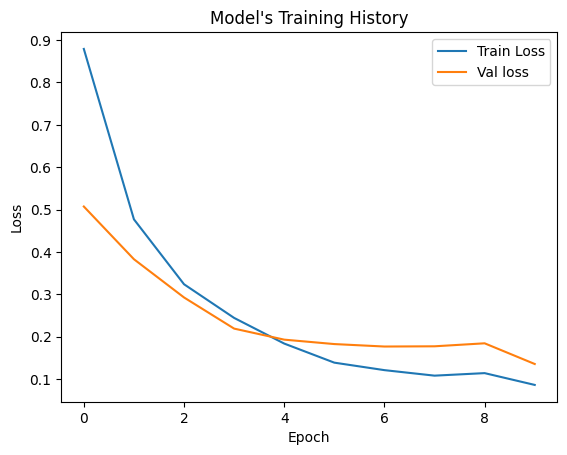

In [10]:
import matplotlib.pyplot as plt

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_loss, label = 'Train Loss')
plt.plot(val_loss, label = 'Val loss')
plt.title('Model\'s Training History')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Predict

In [23]:
y_pred = model.predict(test_ds)
y_pred = np.argmax(y_pred, axis=1)
y_pred

37/37 [==============================] - 10s 273ms/step


array([0, 0, 0, ..., 8, 8, 8], dtype=int64)

In [20]:
model.evaluate(test_ds)

37/37 [==============================] - 9s 238ms/step - loss: 0.1424 - sparse_categorical_accuracy: 0.9585


[0.142384335398674, 0.9585448503494263]

## Evaluation

In [24]:
from sklearn.metrics import classification_report

print(classification_report(test_ds.labels, y_pred, target_names=class_names))

                        precision    recall  f1-score   support

 Bacterial Leaf Blight       0.92      0.97      0.95       120
            Brown Spot       1.00      0.89      0.94       155
     Healthy Rice Leaf       0.97      1.00      0.99       109
            Leaf Blast       0.94      0.96      0.95       175
            Leaf scald       0.99      0.94      0.97       134
Narrow Brown Leaf Spot       0.84      0.96      0.89        96
            Neck_Blast       1.00      1.00      1.00       100
            Rice Hispa       1.00      0.95      0.98       130
         Sheath Blight       0.96      0.98      0.97       163

              accuracy                           0.96      1182
             macro avg       0.96      0.96      0.96      1182
          weighted avg       0.96      0.96      0.96      1182



In [30]:
model.save_weights('../src/models/efficient_net_model_weight.h5')